# Squidpy integration

In this notebook, we will describe some usage principles for using SpatialData with squidpy.

Let's first import some useful libraries and read in a spatialdata dataset.

You might have to install squidpy with `!pip install squidpy`.

In [1]:
from pathlib import Path

import scanpy as sc
import spatialdata as sd
import spatialdata_plot
import squidpy as sq

We chosed a Xenium dataset formatted in the spatialdata format. 
You can download the data from here: [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip). Please rename the file to `xenium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [2]:
sdata = sd.read_zarr("xenium.zarr")
sdata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/xenium_rep1_io/data.zarr
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (25778, 35416), (12889, 17708), (6444, 8854), (3222, 4427), (1611, 2213)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (25778, 35416), (12889, 17708), (6444, 8854), (3222, 4427), (1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D s

SpatialData has a more complex structure than the (legacy) spatial `AnnData` format introduced by `squidpy`. Nevertheless, because it fundamentally uses `AnnData` as table for annotating regions, with some minor adjustments we can readily use any tool from the scverse ecosystem (`squidpy` included) to perform downstream analysis.

More precisely, the `scverse` ecosystem will gradually transition to use `SpatialData` internally; until that moment the function `to_legacy_anndata()` from `spatialdata_io.experimental` can be used to enrich the `AnnData` in `sdata.tables`  objects to be compatible with the legacy `AnnData` format.

Generally (i.e. when a single coordinate system is used), the only adjustment required is to populate `.obsm['spatial']` with the centroids of the geometries being considered, and this is performed automatically by the `spatialdata-io` library. For more complex cases, the converter functions `to_legacy_anndata()` and `from_legacy_anndata()` can be used (see example at the end of the notebook).

## Xenium example

As an example of integration with `Squidpy`, let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [3]:
sq.gr.spatial_neighbors(sdata["table"])

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [4]:
%%time
sc.pp.pca(sdata["table"])
sc.pp.neighbors(sdata["table"])
sc.tl.leiden(sdata["table"])

CPU times: user 1min 39s, sys: 3.31 s, total: 1min 42s
Wall time: 1min 34s


And run the neighbor enrichment analysis in squidpy.

  0%|          | 0/1000 [00:00<?, ?/s]

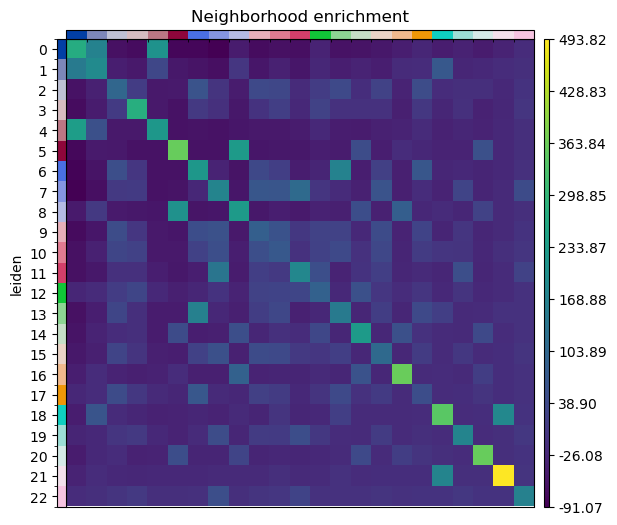

In [5]:
sq.gr.nhood_enrichment(sdata["table"], cluster_key="leiden")
sq.pl.nhood_enrichment(sdata["table"], cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


/Users/macbook/embl/projects/basel/squidpy/src/squidpy/pl/_spatial_utils.py:957: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


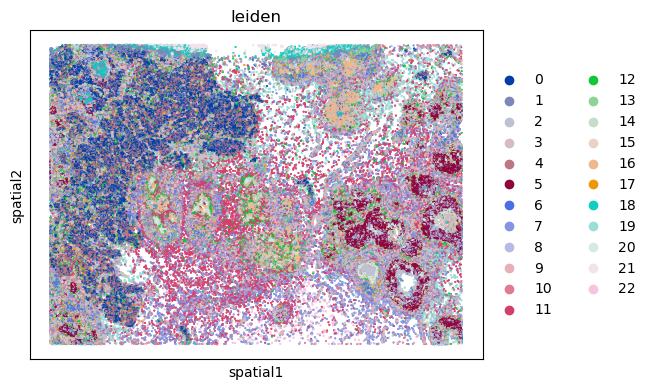

In [6]:
sq.pl.spatial_scatter(sdata["table"], shape=None, color="leiden")

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:709: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


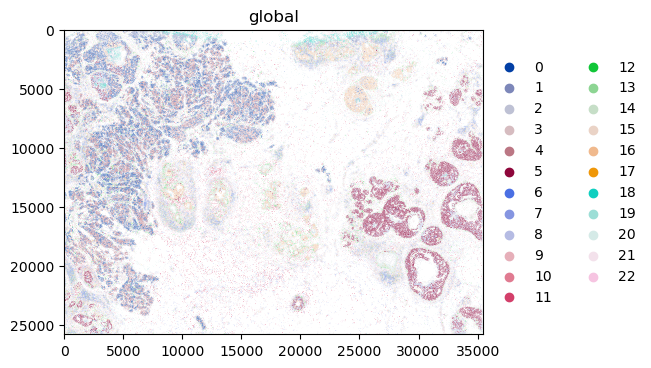

In [7]:
sdata.pl.render_shapes("cell_circles", color="leiden").pl.show(coordinate_systems="global")

## Using the converters from/to the legacy spatial `AnnData` format

We will now show how to convert from/to the legacy spatialdata `AnnData` format. The convertes deal with the complexity of having multiple libraries in the legacy format, and with the generality of coordinate systems in `SpatialData`. For more information please refer to the API documentation of `spatialdata-io`.

In [8]:
from typing import Literal

import matplotlib.pyplot as plt
import scanpy as sc
import spatialdata_io
import spatialdata_plot
import squidpy as sq
from anndata import AnnData
from spatialdata import SpatialData
from spatialdata._core.query.relational_query import _get_unique_label_values_as_index
from spatialdata.datasets import blobs
from spatialdata.models import TableModel
from spatialdata.transformations import Affine, set_transformation
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata

BlobsTypes = Literal["blobs_labels", "blobs_circles", "blobs_polygons", "blobs_multipolygons"]


def blobs_annotating_element(name: BlobsTypes) -> SpatialData:
    """Returns toy data (blobs) with a table annotating the deised element."""
    sdata = blobs(length=50)
    if name == "blobs_labels":
        instance_id = _get_unique_label_values_as_index(sdata[name]).tolist()
    else:
        instance_id = sdata[name].index.tolist()
    n = len(instance_id)
    new_table = AnnData(shape=(n, 0), obs={"region": [name for _ in range(n)], "instance_id": instance_id})
    new_table = TableModel.parse(new_table, region=name, region_key="region", instance_key="instance_id")
    del sdata.tables["table"]
    sdata["table"] = new_table
    return sdata

### Example of conversion from the legacy AnnData to SpatialData

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Dropping coordinate system 'V1_Adult_Mouse_Brain_downscaled_lowres' since it doesn't have relevant        
         elements.                                                                                                 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


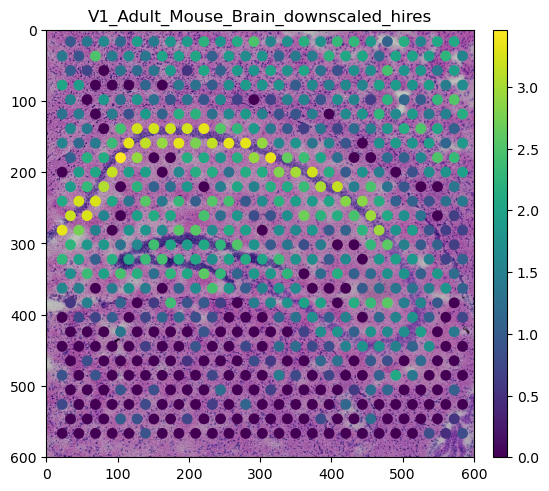

In [9]:
# some datasets you can play around with
# adata = sq.datasets.visium_fluo_adata()
# adata = sq.datasets.merfish()
adata = sq.datasets.visium_hne_adata_crop()

sdata = from_legacy_anndata(adata)

my_gene = "Itpka"
# broken (multiple table not yet supported in spatialdata-plot), this is being fix in https://github.com/scverse/spatialdata-plot/pull/220
sdata.pl.render_images("V1_Adult_Mouse_Brain_hires_image").pl.render_shapes(color=my_gene).pl.show()
plt.show()

### Example of conversion from SpatialData to the legacy AnnData, showing also that affine transformations are handled

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)
/tmp/ipykernel_28047/2875571746.py:28: UserWarning: Converting `region_key: region` to categorical dtype.
  new_table = TableModel.parse(new_table, region=name, region_key="region", instance_key="instance_id")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str in

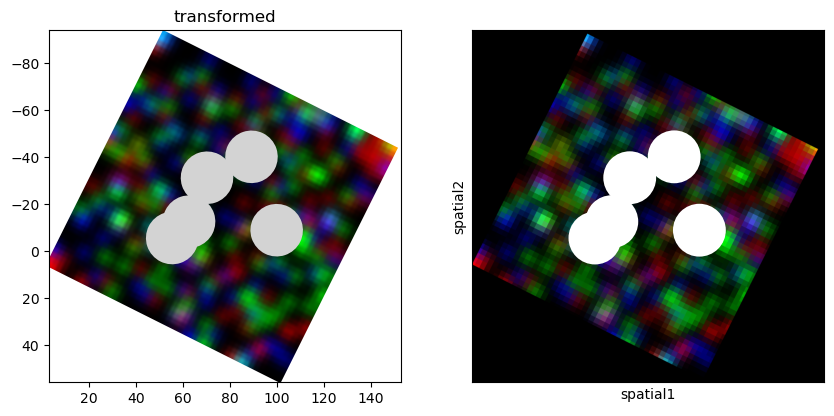

In [10]:
element = "blobs_circles"
sdata = blobs_annotating_element(element)
image = "blobs_multiscale_image"

affine = Affine([[1, 2, 3], [-2, 1, 6], [0, 0, 1]], input_axes=("x", "y"), output_axes=("x", "y"))
set_transformation(sdata[element], affine, "transformed")
set_transformation(sdata[image], affine, "transformed")

adata = to_legacy_anndata(sdata, include_images=True, coordinate_system="transformed")

axes = plt.subplots(1, 2, figsize=(10, 5))[1]
sdata.pl.render_images(image).pl.render_shapes(element).pl.show(coordinate_systems=["transformed"], ax=axes[0])
sc.pl.spatial(
    adata,
    spot_size=300,
    library_id=image,
    img_key="hires",
    na_color="white",
    show=True,
    crop_coord=(0, 2000, 0, 2000),
    ax=axes[1],
)